# Introduksjon til vitenskaplige beregninger: Prosjekt 1


## Innledning:
I dette prosjektet ser vi på en sterkt forenklet en-dimensjonal modell for havets absorpsjon av karbon fra atmosfæren, hvor vi blant annet ser bort ifra havstrømninger, temperatur, vind og geografisk lokasjon. Prosjektet har to oppgaver. 

I den første oppgaven ser vi på grunt havvann med maksimal dybde på 100 m. Slike farvann er typisk å finne i kystfarvann. Her bruker vi en startkonsentrasjon på $0 mol\cdot m^{-3}$  og en likevektskonsentrasjon mellom atmosfæren og havet, $$C_{eq} = Hp_{CO_2} = 2.099 mol\cdot m^{-3}$$,hvor vi har antatt ideell gass for $CO_2$ og lineært forhold mellom likevektskonsentrasjonen og partialtrykket $p_{CO_2}$. Vi har også antatt at med en gang $CO_2$ blir tatt opp i havet så blir det umiddelbart omgjort til DIC(dissolved inorganic carbon). DIC omfatter følgende grupper av oppløst karbon: $H_2CO_3, HCO_3^- $ og $CO_3^2-$. Vi har også antatt en konstant massetransport-koeffisient $k_w$. Ved å bruke denne starttilstand og disse forenklingene kan vi i oppgave 1 undersøke hvor raskt havet responderer på endring av konsentrasjon $CO_2$ i atmosfæren i en 180-dagers syklus. 

I den andre delen ser vi direkte på økning av $CO_2$ i atmosfæren. Det er estimert at konsentrasjonen $CO_2$ øker med 2.3 ppm hvert år siden den industrielle revolusjon.. Vi antar nå at denne økningen skjer jevnt fordelt over året og ser på endringen av konsentrasjon $CO_2$ over ti år. Dette betyr at likevektskonsentrasjonen vil øke jevnt med 2.3 ppm/år. Vi ser nå på hele havet med en gjennomsnittlig dybde på 4000 m. På grunn av endringen i dybden ser vi nå på en annen modell for diffusivitetskonstanten enn i oppgave 1. Vi antar at til å begynne med så er hele havet i likevekt med atmosfæren og at til ethvert tidspunkt så er atmosfæren og konsentrasjonen ved havoverflaten i likevekt. Disse antakelsene gjør at vi i modellen vår kan estimere hvor mye masse $CO_2$ havet absorberer hvert år ved å simulere endringen av konsentrasjon i havet over ti år. 


Hele modellen vår er bygd på å løse diffusivitetlikningen med fluks på grunn av diffusivitet, gitt av fricks lov,  og fluks på grunn av massetransport som grensebetingelser for henholdsvis havbunn og havoverflate. For å løse dette likningssettet numerisk diskretiserer vi de partielle difflikningene og utrykker det totale systemet som må løses på matriseform, får da matriselikningen $LC^{i+1} = RC^i + \frac12(S^i + S^{i+1})$. Hvor $L$ og $R$ er tridiagonale matriser. Dermed kan vi ved å bruke Thomas algoritmen(TDMA) til å løse systemet iterativt for hvert diskretisert tidspunkt og hvert punkt i havet. 

Diffusjonslikningen som brukes til å løse begge oppgavene er gitt ved:
$$\frac{\partial C(z,t)}{\partial t} = \frac{\partial}{\partial z}\left(K(z)\frac{\partial C(z,t)}{\partial t}\right).$$



## Oppgave 1 

$CO_2$ absoropsjon ved kysten $L = 100 m $. Antar $[DIC]_{t=0} = 0$. Kjører simmulasjon over 180 dager,ved å bruke  diffusivitet

$$
K(z) = K_0 + K_a\frac{z}{z_a} \exp(-z/z_a) + K_b \frac{L-z}{z_b}\exp(-\frac{L-z}{z_b})
$$

hvor $K_0 = 10^{-3}, K_a = 2 \cdot 10^{-2}, z_a = 7, K_b = 5 \cdot 10^{-2}, z_b = 10$. 



In [11]:
'''Nødvendige bibloteker'''

import numpy as np #arrays
import matplotlib.pyplot as plt #plotting
import matplotlib as mpl


from scipy.sparse import diags #lineær algebra
from scipy.integrate import simps #for summering 
from numba import jit #optimaliserer kjøretiden
import time  #Til å ta tiden
%matplotlib inline

In [7]:
'''Funksjoner til å kjøre simulasjoner'''

#Funksjoner gitt på forhånd
@jit(nopython = True)
def tdma_solver(a, b, c, d):
    N = len(d)
    c_ = np.zeros(N-1)
    d_ = np.zeros(N)
    x  = np.zeros(N)
    c_[0] = c[0]/b[0]
    d_[0] = d[0]/b[0]
    for i in range(1, N-1):
        c_[i] = c[i]/(b[i] - a[i-1]*c_[i-1])
    for i in range(1, N):
        d_[i] = (d[i] - a[i-1]*d_[i-1])/(b[i] - a[i-1]*c_[i-1])
    x[-1] = d_[-1]
    for i in range(N-2, -1, -1):
        x[i] = d_[i] - c_[i]*x[i+1]
    return x


def tdma(A, b):
    x = tdma_solver(A.diagonal(-1), A.diagonal(0), A.diagonal(1), b)
    return x

#Lager så nyttige funksjoner til bruk i begge oppgavene

def makeKr(K): #en slags diffusivitet, hjelpestørrelse til matrisene
    
    Kr = np.zeros(K.size-2)

    for n in range(K.size-2):
        Kr[n] = K[n+1] - K[n-1]
    return Kr


def makeLAndR(K, Ceq): #Funksjon for å få L og R matrisene
    
    alpha = dt/(2*dz**2) #hjelpekonstanter til matrisene

    gamma = 2*alpha*kw*dz*(1-(K[1]-K[0])/(2*K[0]))
    Kr = makeKr(K)
    
    S = np.zeros((z.size, t.size)) #S-matrisa med grensebetingelser
    S[0,:] = 2*gamma*Ceq
    
    L_main = 1 + 2*alpha*K #Lager diagonalene til L
    L_upper = -alpha/4*Kr - alpha*K[1:-1]
    L_lower = alpha/4*Kr - alpha*K[1:-1]
    
    L_main[0] += gamma # Legger til elementer på endene 
    L_upper = np.insert(L_upper, 0,-2*alpha*K[0], axis = 0)
    L_lower = np.append(L_lower,-2*alpha*K[-1])

    R_main = 1 - 2*alpha*K # Lager diagonalene til R
    R_upper = alpha/4*Kr + alpha*K[1:-1]
    R_lower = -alpha/4*Kr + alpha*K[1:-1]
    
    R_main[0] -= gamma # Legger til elementer på endene 
    R_upper = np.insert(R_upper, 0, 2*alpha*K[0], axis = 0) # legger til på starten
    R_lower = np.append(R_lower, 2*alpha*K[-1]) #Legger til på slutten
        

    L = diags([L_upper, L_main, L_lower], offsets = [1, 0, -1]) #Lager tridiagonalmatrise ved scipys sparse format
    R = diags([R_upper, R_main, R_lower], offsets = [1, 0, -1])
    
    return L, R, S


def solveForC(K, C, Ceq): #Funksjonen for å finne konsentrasjonen C iterativt.
    L, R, S = makeLAndR(K, Ceq)
    
    for i in range(C[0,:].size-1): #Iterer meg gjennom alle tidspunktene og finner konsentrasjonen for alle z-punkter
        V = R.dot(C[:,i]) + 0.5*(S[:,i]+S[:,i+1])
        C[:,i+1] = tdma(L, V)
    return C


In [8]:
'''Oppgave 1: Simulasjon'''

t1 = time.time()

#Definerer først diverse konstanter
l = 100 #dybde
dt = 60*60 # tidssteg
dz = 0.1 # lengdested
K0 = 10**(-3) # konstanter til diffusivitet
Ka = 2*10**(-2)
za = 7
Kb = 5*10**(-2)
zb = 10

kw = 6.97*10**(-5) # massetransport koeffsient
Ceq = 5060 * 415 * 10**(-6) # likevektskonsentrasjonen 
C0 = 0                    #Startkonsentrasjon av DIC


z = np.arange(0, l, dz) #Oppretter arrays for rom og tid basert på skrittlengdenee
t = np.arange(0, 180*24*60*60, dt)

Ci = np.zeros((z.size, t.size)) #startkonsentrasjon verdier
Ci[:,0] = C0

K = K0 + Ka * z/za * np.exp(-z/za) + Kb * (l-z) / zb * np.exp(-(l-z) / zb) #diffusivitet

C = solveForC(K, Ci, Ceq) #Finner konsentrasjonen

t2 = time.time()

print(f'Kjøretid for kode: {round(t2-t1,3)}s')


Kjøretid for kode: 1.948s


In [9]:
'''Oppgave 1: Max og min konsentrasjonener av DIC som funksjon av tid'''


plt.figure(1) #Plotter konsentrasjonen for max og min verdier i dybden

plt.plot(t/(dt*24), np.max(C, axis = 0), label = 'max')
plt.plot(t/(dt*24), np.min(C, axis = 0), label = 'min')
plt.plot(t/(dt*24), np.max(C, axis = 0) - np.min(C, axis = 0), '--', label = 'Differanse')
plt.plot(t/(dt*24), np.ones(len(t))*Ceq, '--', label = 'Likevekt')


plt.title('Figur 1: Konsentrsjon av DIC ved max og min')
plt.xlabel('tid[dager]')
plt.ylabel(r'Konsentrasjon[mol/$m^3$]')
plt.grid()
plt.legend()
plt.show()


Ser at max og min konvergerer ganske raskt mot likevektskonsentrasjonen, ser at etter 100 dager er omtrentlig forskjellen mellom max og min neglisjerbar.

<IPython.core.display.Javascript object>


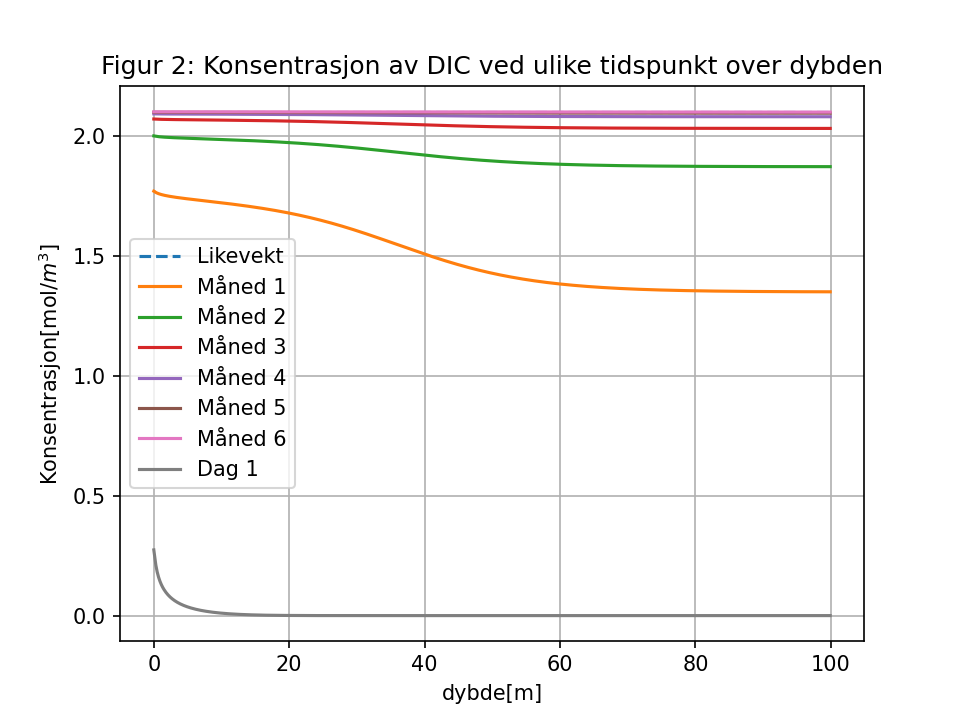

In [30]:
'''Oppgave 1: Konsentrasjon av DIC ved ulike t som funksjon av dybde'''

plt.figure(2)
plt.plot(z, np.ones(len(z))*Ceq,'--' ,label = 'Likevekt') #Plotter konsentrasjonen for ulike måneder sammen med likevektskonsentrasjonen

for i in range(1,7):
    plt.plot(z, C[:,24*29*i], label = f'Måned {i}')

plt.plot(z, C[:,1], label ='Dag 1')
plt.grid()
plt.xlabel('dybde[m]')
plt.ylabel(r'Konsentrasjon[mol/$m^3$]')
plt.title(f'Figur 2: Konsentrasjon av DIC ved ulike tidspunkt over dybden')
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


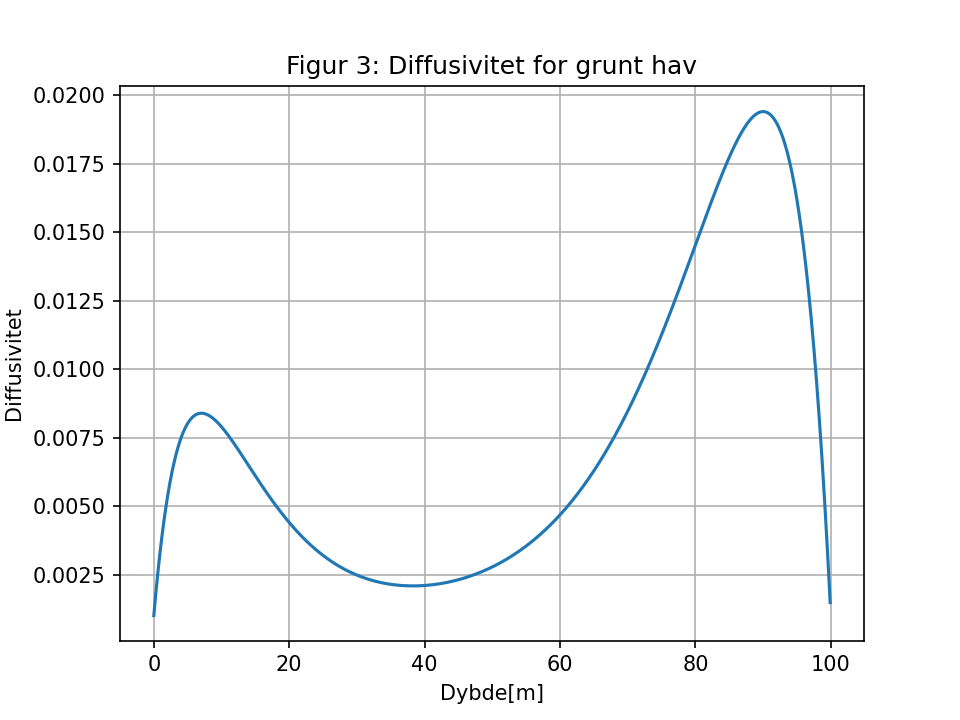

In [31]:
'''Diffusivitet oppgave 1'''

plt.figure(3) #plotter difusviteten som funksjon av dybden
plt.plot(z, K)
plt.grid()
plt.title('Figur 3: Diffusivitet for grunt hav')
plt.xlabel('Dybde[m]')
plt.ylabel('Diffusivitet')
plt.show()

I figur 2 vises konsentrasjonen av DIC ved ulike tidspunkt. For hver måned vi hopper fremover blir konsentrasjonens z-avhengighet mindre og mindre, altså fordeler DIC-molekylene seg jevnt over hele dybden ettersom tiden får gå sin gang. Etterhvert vil også konsentrasjonene være tilnærmet lik likevektskonsentrasjonen, da vil heller ikke tiden ha noen innvirkning på hvordan fordelingen ser ut. Iløpet av ca 100 dager er så si konsentrasjonene helt jevnt fordelt og lik likevektskonsentrasjonen, altså er konsentrasjonen i vannet lik atmosfære-konsentrasjonen. Kan derfor si at endringen av CO2 - konsentrasjonen i atmosfæren er liten i forhold til konsentrasjonen av DIC I vannet slik at endringen av konsentrasjonen i vannet er i takt med atmosfæren. 

I figur 3 vises diffusiviteten for grunt vann som har en klar sammenheng med fordelingen av konsentrasjon DIC. Dette sees best ved å se på linjen for måned 1. Ved de første 10 meterne er stigningstallet svakt synkende før så stigningstallet blir brattere negativt, før det igjen flater ut . Dette har da korrelasjon til diffusiviteten som først er stigende før den når et maksimum (ved ca. 10 meter) og deretter synker før den igjen øker og når et nytt maksimum. 


## Oppgave 2
$CO_2$ absorpsjon av havet. Bruker nå $ L = 4000 m $. Nå er diffusiviteten

$$K(z) = K_1+\frac{K_0-K_1}{1+e^{-a(z-z_0)}}$$

hvor $K_0 = 10^{-4} m^2/s, K_1 = 10^{-2} m^2/s, a = 0.5 m^-1, z_0 = 100m$

$CO_2$ øker med ca $2.3$ ppm/år siden den industrielle revolusjon. Vi må altså ta høyde for at likevektskonsenetrasjonen endrer seg og ikke lenger er konstant som i oppgave 1. Antar at havet er i konstant likevekt med atmosfæren. Vi studerer hvordan havet absorberer $CO_2$ når konsentrasjonen øker. 


In [48]:
'''Oppgave 2: Simulasjon'''

t1 = time.time()

#Diverse konstanter:
l = 4000 #sluttdybde
T = 60*60*24*365*10 + 1 #slutt-tid: 10 år og 1 sekund
H = 5060 #konstant til likevekt
pCO20 = 415 * 10**(-6) #inertiel partielltrykk
dCO2 = 2.3 * 10**(-6) #økning i partielltrykk
dt = 60*60*24 #tidssteg: 1 dag
dz = 4 #dybdesteg
K0 = 10**(-4) #konstanter til diffusivitet
K1 = 10**(-2)
a = 0.5
z0 = 100

z = np.arange(0, l, dz) #dybde-array
t = np.arange(0, T, dt) #tidsarray

K = K1 + (K0-K1)/(1+np.exp(-a*(z-z0))) #diffusivitet

Ceq = np.ones(len(t)) * H * pCO20 #Lager likevektskonsentrasjoner til hvert tidspunkt 

for i in range(1, len(t)):
    Ceq[i] = Ceq[0] + H*dCO2/(365) * i #Omgjør raten av vekst CO2, slik at det passer med tidssteget


Ci = np.zeros((z.size, t.size)) #startkonsentrasjon verdier
Ci[:,0] = Ceq[0]


C = solveForC(K, Ci, Ceq) #Finner konsentrasjonen for dette systemet
t2 = time.time()

print(f'Kjøretid for kode: {round(t2-t1,3)}s')


Kjøretid for kode: 0.661s


<IPython.core.display.Javascript object>


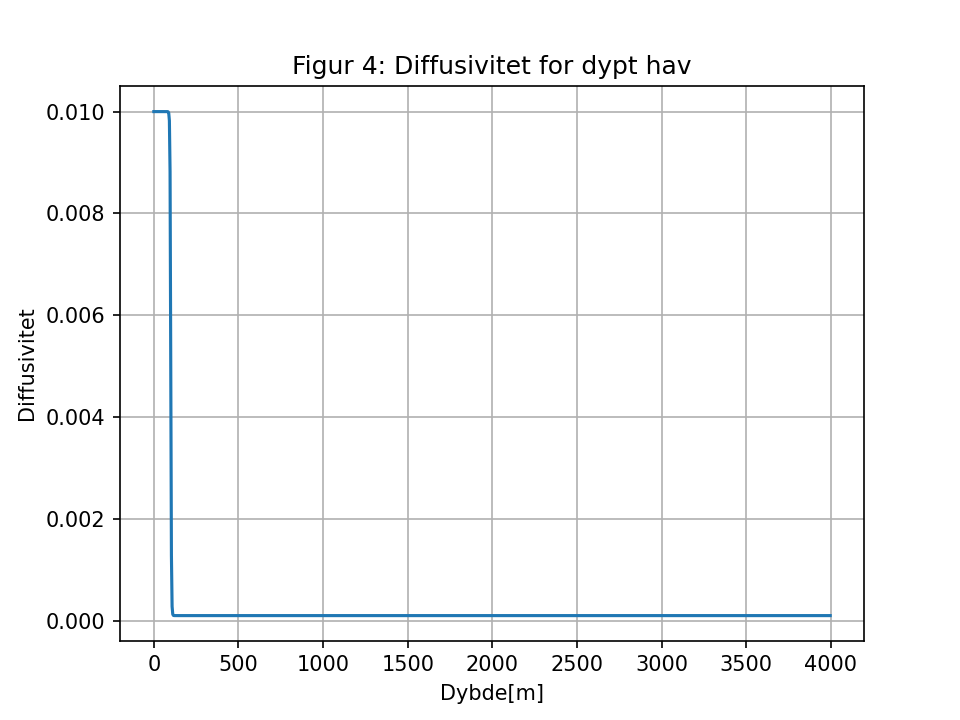

In [49]:
'''Diffusivitet oppgave 2'''

plt.figure(4) #plotter diffusviteten som funksjon av dybden
plt.plot(z, K)
plt.grid()
plt.title('Figur 4: Diffusivitet for dypt hav')
plt.xlabel('Dybde[m]')
plt.ylabel('Diffusivitet')
plt.show()

Figur 4 viser diffusiviteten som funksjon av dybden. Verdt å merke seg at den er relativt høy for grunne farvann før den blir brått veldig lav for dypere farvann. Det vil altså være større sirkulasjon og dermed høyere konsentrasjon ved grunt vann.

In [50]:
'''Oppgave 2: Konsentrasjon ved ulike år som funksjon av dybden'''

plt.figure(5)

for i in [0, 2.5, 5,10]: #Plotter konsentrasjonen ved ulike år 
    plt.plot(z, C[:,int(i*365)], label = f'År {2020+i}')
    plt.plot(z, np.ones(z.size)*Ceq[int(i*365)],'--' ,label = f'Likevekt {i+2020}')

plt.grid()
plt.title('Figur 5: Konsentrasjon av CO2 i havet')
plt.xlabel('dybde[m]')
plt.ylabel(r'konsentrasjon [mol/$m^3$]')
plt.legend()
plt.show()


<IPython.core.display.Javascript object>



Figur 5 viser konsentrasjon av $CO_2$ i havet for et utvalg av tidspunkter som funksjon av dybden.
Observerer i figur 5 at konsentrasjonen holder seg ved likevektskonsentrasjonen frem til ca. z = 100 m før den synker i verdi. Dette gir mening da det er ved grunt vann det er størst diffusivitet(ref figur 4) i havet, og dermed størst turbulens, som driver CO2 opp fra dypere vann til grunnere vann som illustrert i figur 2 i oppgaveteksten. Dette gjør da at det blir en veldig sakte økning av konsentrasjonen i dypere farvann sammenlignet med grunnere farvann.


<IPython.core.display.Javascript object>


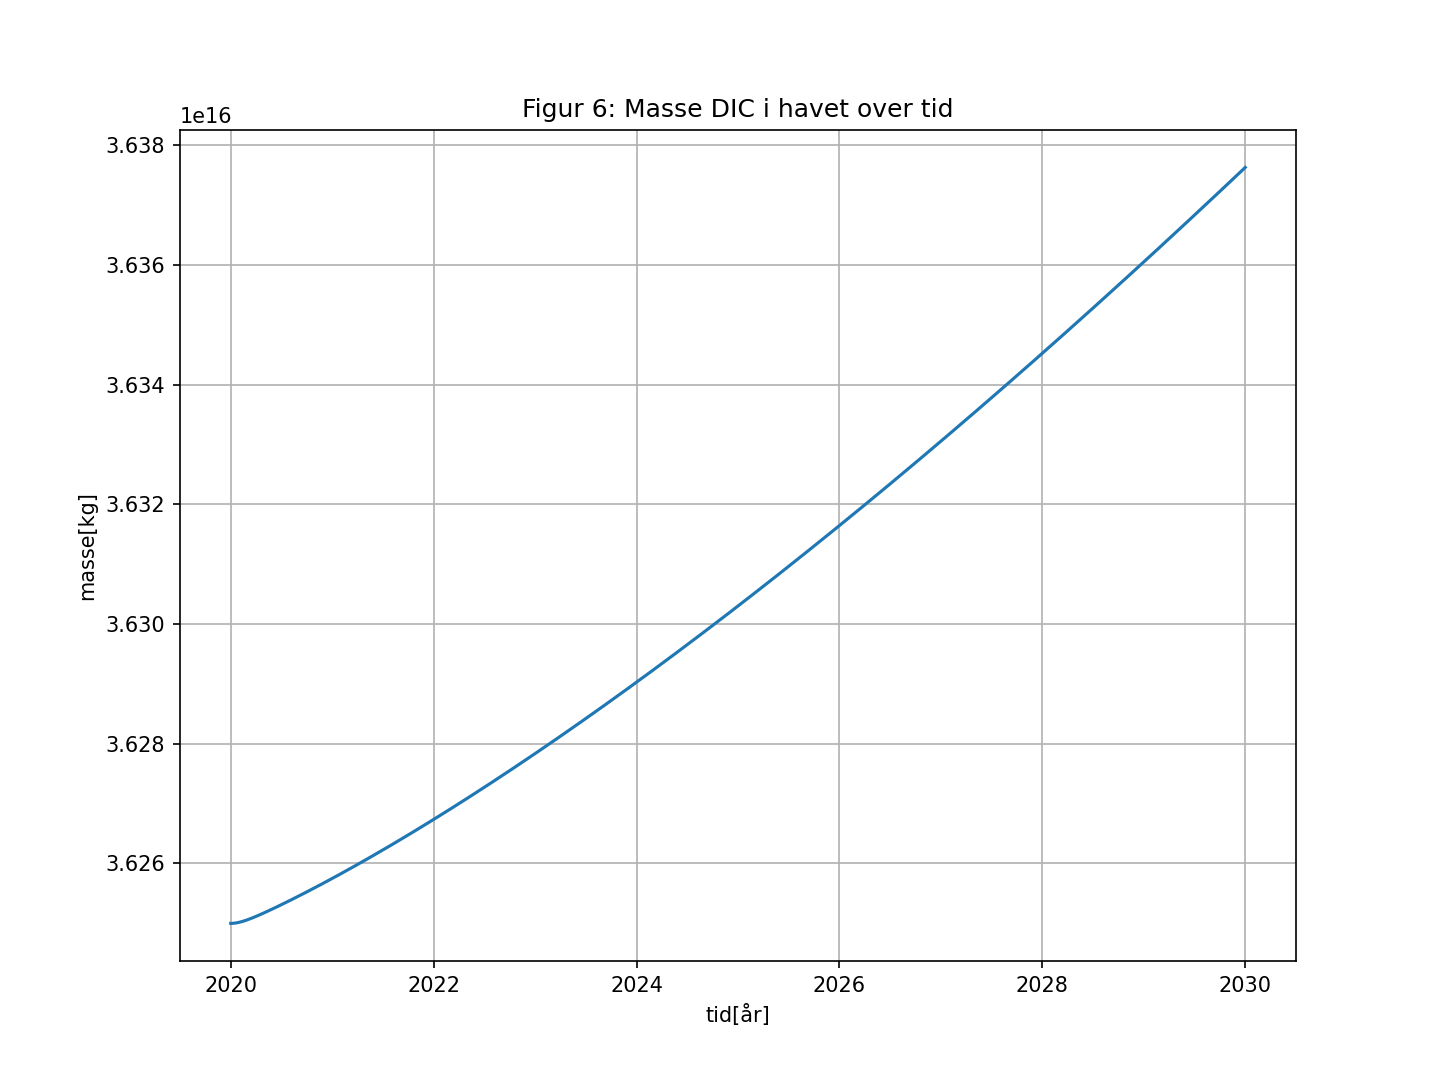

In [63]:
'''Oppgave 2: Masse DIC som funksjon av tid'''

A = 360*10**(12) #areal[m^2]
M_DIC = 12*10**(-3) #Molar masse [kg/mol]

Csum = np.zeros(t.size) #Finner totalkonsentrasjon i havet til ethvert tidspunkt.



for i in range(t.size):
    Csum[i] = simps(C[:,i]) #integerer opp konsentrasjonen for hvert tidspunkt

m_DIC = Csum * A * dz * M_DIC #masse [mol/m^3 * m^2 * m * kg/mol] = [kg]



#Plotter massen av DIC over tid


plt.figure(6)
plt.plot(t/(dt*365)+2020, m_DIC)
plt.title('Figur 6: Masse DIC i havet over tid')
plt.xlabel('tid[år]')
plt.ylabel('masse[kg]')
plt.grid()
plt.show()


Figur 6 viser utviklingen av masse DIC i havet over tid.

In [37]:
'''Oppgave 2: Gjennomsnittlig masse absorbert av havet'''


dm_DIC = m_DIC[-1] - m_DIC[0] #Differanse i masse karbon


print(f'Total masse CO2 absorbert av havet: {"{:e}".format(dm_DIC/(10))} kg/år') #Deler på 10 år for å finne gjennomsnitt per år


Total masse CO2 absorbert av havet: 1.262913e+13 kg/år


Målet med denne simulasjonen var å se hvor mye av de menneskeskapte utslippene av karbon som blir absorbert av havet. Vi har fått et litt høyere svar enn Gruber(svaret vårt er omtrent 5 ganger så stort), men ganske nært med tanke på alle forenklingene som har blitt gjort. Blant annet har det blitt antatt at konsentrasjonen av menneskeskapt $CO_2$ i atmosfæren øker med $2.3 ppm$ hvert år, men dette er økningen i den totale mengden $CO_2$ i atmosfæren hvert år. Altså er den faktiske økningen forårsaket av mennesker betydelig lavere, noe som ville ført til et mindre avvik. I tillegg er påvirkninger fra naturen, som for eksempel vannstrømmer, vind og temperaturforskjeller ikke tatt hensyn til. Forenklinger som endimensjonalitet, konstant likevekt og konstant innkommende fluks har også påvirket resultatet, men det er vanskelig å si i hvor stor grad og i hvilken retning de har endret resultatet. Til tross for alle disse forenklingene, er resultatet såpass nære Grubers resultat at det kan konkluderes med at modellen er ganske god.